# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [1]:
# code here
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from tabulate import tabulate

In [2]:
import torch.nn as nn
import torchvision.datasets as datasets
from torchsummary import summary
import torchvision
import torch
import torchvision.transforms as transforms

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [3]:


batch_size = 16

transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

torch.Size([16, 3, 32, 32])
torch.Size([16])


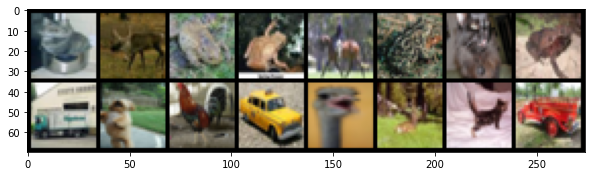

In [5]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

1. MLP-only model

In [60]:


class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3*32*32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 3*32*32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(x.size(0), 3, 32, 32)


2. CNN-MLP combination model

In [7]:
class ComboAutoEncoder(nn.Module):
    def __init__(self, input_size=3072, code_size=32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=4,stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 8 * 8, code_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 4 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (4, 8, 8)),
            nn.ConvTranspose2d(4, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


3. CNN-only model

In [8]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*4*4, 32)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        return self.fc(x)


class CNNDecoder(nn.Module):
    def __init__(self):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(32, 64*4*4)
        self.relu1 = nn.ReLU(inplace=True)
        self.unflatten = nn.Unflatten(1, (64, 4, 4))
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.relu1(x)
        x = self.unflatten(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.relu3(x)
        x = self.conv3(x)
        return self.sigmoid(x)


class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)



### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# code here
def trainModel(model, trainloader, testloader, epochs=10):
    criterion = nn.MSELoss().to(device)
    
    trainLoss=[]
    testLoss=[]
    epochTime = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

    for e in range(epochs):
        runningLoss = 0.0
        startTime = time.time()
        for i, data in enumerate(trainloader):
            images, _ = data
            images = images.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            runningLoss =runningLoss + loss.item()
        else:
            trainLoss.append(runningLoss / len(trainloader))
        
        with torch.no_grad():
            model.eval()
            outLoss = 0.0
            for data in testloader:
                images, _ = data
                images = images.to(device)
                output = model(images)
                loss = criterion(output, images)
                outLoss =outLoss + loss.item()
            testLoss.append(outLoss / len(testloader))
        endTime = time.time()
        epochTime.append(endTime - startTime)
    return trainLoss, testLoss, epochTime

In [11]:

def reconstructImages(model, testloader):
    data_iter = iter(testloader)
    images, _ = next(data_iter)
    print("Original Images")
    grid = torchvision.utils.make_grid(images)
    imshow(grid)
    device = next(model.parameters()).device
    images = images.to(device)
    with torch.no_grad():
        reconstructed = model(images)
        reconstructed = reconstructed.cpu()
    print("Reconstructed Images")
    grid = torchvision.utils.make_grid(reconstructed)
    imshow(grid)


In [12]:
def plot(trainLoss,testLoss,arr):
    plt.plot(arr, trainLoss, "r--")
    plt.plot(arr, testLoss, "b--")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [13]:


def printTable(trainLoss,testLoss,timeTakenperEpoch,epochs=10):
  header=["Epoch", "Train Loss", "Test Loss","Time Taken"]
  l=[]
  for i in range(epochs):
    l.append([i+1,trainLoss[i],testLoss[i],timeTakenperEpoch[i]])
  print(tabulate(l,header))

## MLP-only model

In [14]:
epochs=10

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1     0.0304521    0.0267131       20.0806
      2     0.0256751    0.025208        18.0688
      3     0.0251365    0.0248718       19.3024
      4     0.0243532    0.0237596       18.0152
      5     0.0237264    0.0238228       18.9567
      6     0.0236511    0.0236558       18.9127
      7     0.0235933    0.0235439       19.7387
      8     0.0235213    0.0234352       18.6286
      9     0.0234658    0.0236545       18.4653
     10     0.0234082    0.0235228       18.8022


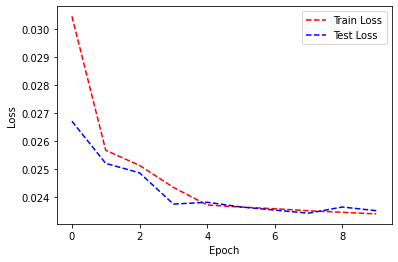

Original Images


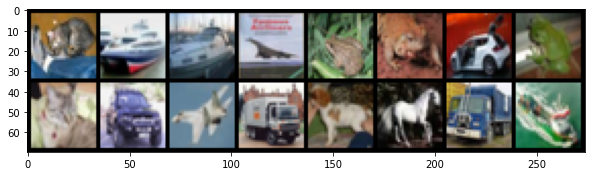

Reconstructed Images


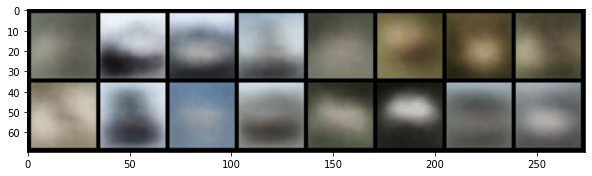

In [61]:
mlp = MLPAutoEncoder().to(device)
arr = list(range(epochs))
trainLoss, testLoss, epochTime = trainModel(mlp, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
plot(trainLoss,testLoss,arr)
reconstructImages(mlp, test_loader)

## CNN-MLP combination model

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1     0.0251951    0.0220427       24.3508
      2     0.0217294    0.0216647       20.5506
      3     0.021592     0.0214661       20.3137
      4     0.0212532    0.020888        20.1181
      5     0.0209017    0.0208992       21.0801
      6     0.0208706    0.0211724       20.5713
      7     0.0208458    0.0209338       19.7386
      8     0.0208306    0.0209612       20.6779
      9     0.0208116    0.0207308       20.3867
     10     0.0207886    0.0209285       19.827


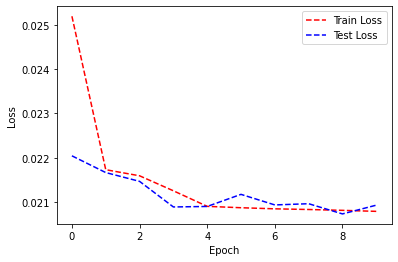

Original Images


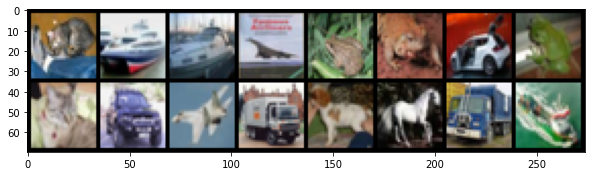

Reconstructed Images


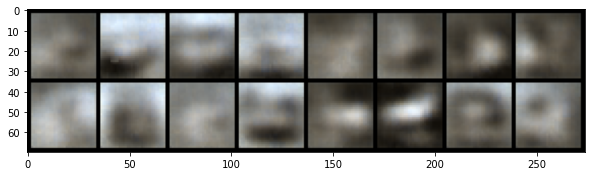

In [16]:
cnnmlp = ComboAutoEncoder().to(device)
trainLoss, testLoss, epochTime = trainModel(cnnmlp, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(cnnmlp, test_loader)


## CNN-only model

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1     0.0163503    0.0126732       24.3508
      2     0.012613     0.0123924       20.5506
      3     0.0123902    0.0122644       20.3137
      4     0.0122014    0.0121668       20.1181
      5     0.0121104    0.0120889       21.0801
      6     0.0120495    0.0121741       20.5713
      7     0.0120012    0.0120415       19.7386
      8     0.0119851    0.0119966       20.6779
      9     0.0119657    0.0120469       20.3867
     10     0.0119403    0.0119179       19.827


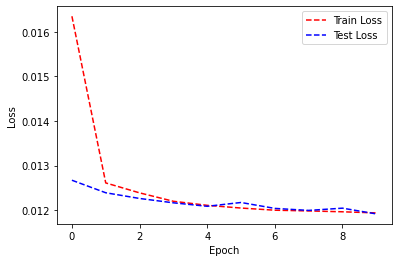

Original Images


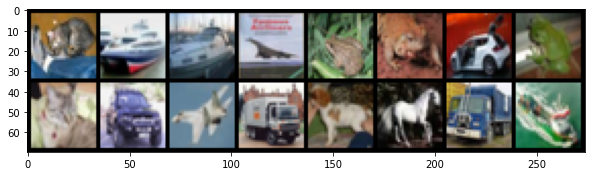

Reconstructed Images


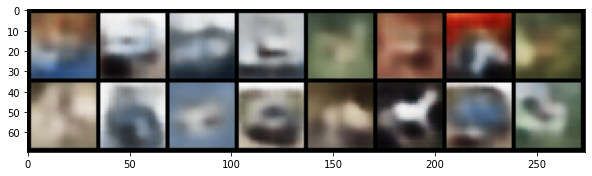

In [17]:
cnn = CNNAutoEncoder().to(device)
trainLoss, testLoss, epoch_time = trainModel(cnn, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(cnn, test_loader)

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, representation_size):
        super(Autoencoder, self).__init__()

        encoderLayers = [
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, representation_size)
        ]
        self.encoder = nn.Sequential(*encoderLayers)

        decoderLayers = [
            nn.Linear(representation_size, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        ]
        self.decoder = nn.Sequential(*decoderLayers)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    


### Representation size 10

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1     0.0241894    0.0217598       24.8298
      2     0.0214956    0.0216272       24.734
      3     0.0212342    0.0214114       24.6575
      4     0.0211183    0.0211057       24.8656
      5     0.0210364    0.0211455       25.1604
      6     0.0209704    0.0210465       24.7886
      7     0.0209185    0.0218473       24.6643
      8     0.0208662    0.0209912       25.4477
      9     0.0208066    0.0209195       24.7659
     10     0.0207996    0.0208697       25.1463


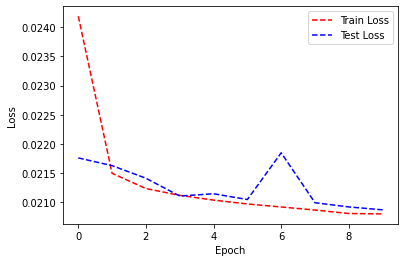

Original Images


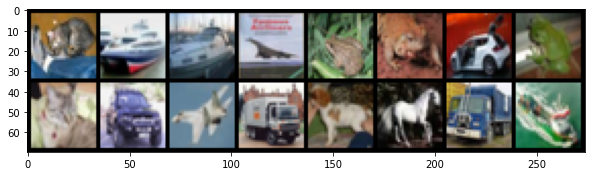

Reconstructed Images


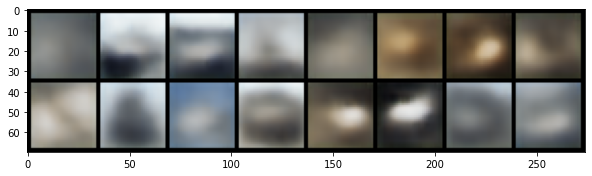

In [19]:
ae10 = Autoencoder(10).to(device)
trainLoss, testLoss, epochTime = trainModel(ae10, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae10, test_loader)

### Representation size 32

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1     0.0199989    0.0158839       25.7478
      2     0.013619     0.0130112       25.3411
      3     0.0130378    0.0128256       25.9576
      4     0.0128195    0.0127177       26.5145
      5     0.0127004    0.0130415       25.6514
      6     0.0126307    0.012673        25.3082
      7     0.0125222    0.0125109       25.4296
      8     0.0124892    0.0126396       25.4596
      9     0.0124324    0.0125735       25.9074
     10     0.0123995    0.0124612       25.2813


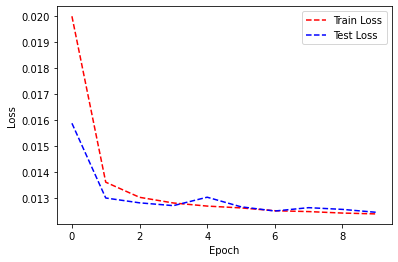

Original Images


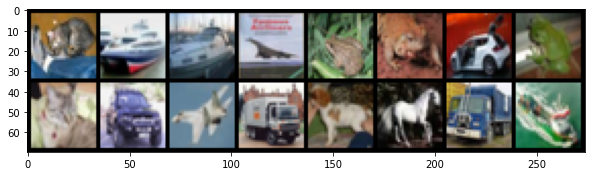

Reconstructed Images


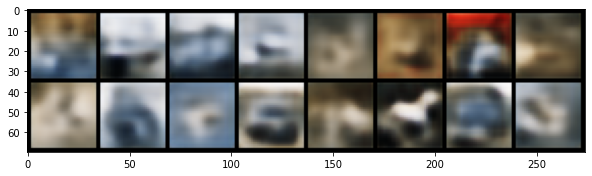

In [20]:
ae32 = Autoencoder(32).to(device)
trainLoss, testLoss, epochTime = trainModel(ae32, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae32, test_loader)

### Representation size 100

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1    0.0174354    0.0112119        25.7634
      2    0.0103361    0.00911906       25.3372
      3    0.00893014   0.00825706       25.5072
      4    0.00823105   0.00782946       25.5449
      5    0.00789279   0.00761322       25.5938
      6    0.00767433   0.00763567       25.3383
      7    0.00752883   0.00763679       25.2341
      8    0.00743861   0.00774031       25.3856
      9    0.00737865   0.00723269       25.3413
     10    0.00726259   0.00711082       26.6122


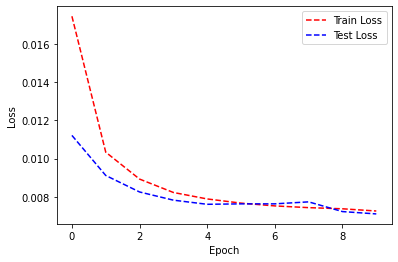

Original Images


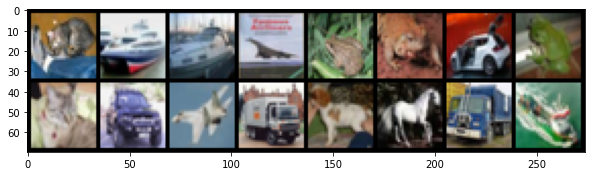

Reconstructed Images


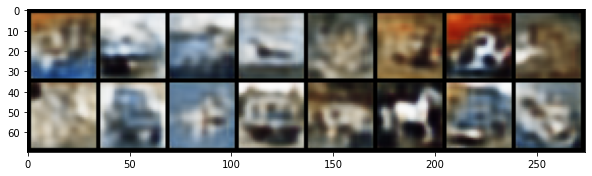

In [21]:
ae100 = Autoencoder(100).to(device)
trainLoss, testLoss, epochTime = trainModel(ae100, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae100, test_loader)

### Representation size 1000

  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1    0.0176193    0.0110114        31.8533
      2    0.0100511    0.00865628       32.0817
      3    0.00843731   0.00832597       32.2629
      4    0.00767673   0.00723743       31.8935
      5    0.00725352   0.00716505       32.5002
      6    0.00703168   0.0068887        32.4811
      7    0.00688633   0.00663253       31.8283
      8    0.00679795   0.00681316       32.9873
      9    0.00671481   0.00667268       32.3536
     10    0.00651801   0.00641687       31.754


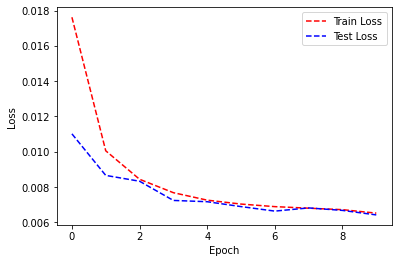

Original Images


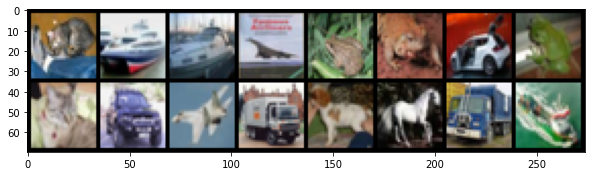

Reconstructed Images


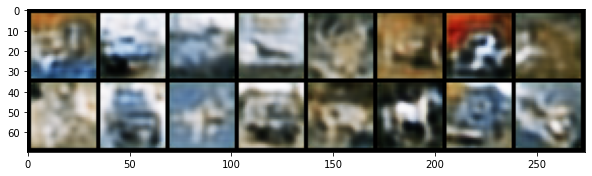

In [22]:
ae1000 = Autoencoder(1000).to(device)
trainLoss, testLoss, epochTime = trainModel(ae1000, train_loader, test_loader)
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae1000, test_loader)

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, numEncoderLayers, numDecoderLayers):
        super(Autoencoder, self).__init__()
        
        self.numEncoderLayers=numEncoderLayers
        self.numDecoderLayers=numDecoderLayers

        self.encLayers=[]
        inChannels,outChannels = 3,16

        
        for i in range(0,numEncoderLayers):
            self.encLayers.append(nn.Conv2d(inChannels, outChannels, kernel_size=3, stride=2, padding=1))
            self.encLayers.append(nn.BatchNorm2d(outChannels))
            self.encLayers.append(nn.ReLU(inplace=True))
            inChannels = outChannels
            outChannels =outChannels * 2
        self.encoder = nn.Sequential(*self.encLayers)
 
        self.decLayers = []
        outChannels = inChannels // 2

        for i in range(0,numDecoderLayers):
            if i == numDecoderLayers - 1:
              self.decLayers.append(nn.ConvTranspose2d(inChannels, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
              self.decLayers.append(nn.Tanh())
            else:
              self.decLayers.append(nn.ConvTranspose2d(inChannels, outChannels, kernel_size=3, stride=2, padding=1, output_padding=1))
              self.decLayers.append(nn.BatchNorm2d(outChannels))
              self.decLayers.append(nn.ReLU(inplace=True))
            inChannels = outChannels
            outChannels = outChannels // 2
        self.decoder = nn.Sequential(*self.decLayers)

    def forward(self, x):
        enc = self.encoder(x)
        return self.decoder(enc)


### Number of layers = 1

In [24]:
ae11 = Autoencoder(1, 1).to(device)
trainLoss, testLoss, epochTime = trainModel(ae11, train_loader, test_loader)


  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1   0.00539725   0.000883669       16.4813
      2   0.000403465  0.000309267       15.4137
      3   0.000271384  0.0002496         15.3701
      4   0.000249461  0.000301835       16.0801
      5   0.000235741  0.000229094       15.4091
      6   0.000221356  0.000238608       15.6039
      7   0.000215706  0.000222358       15.5993
      8   0.000213679  0.000214606       15.9961
      9   0.000212664  0.000214135       15.5056
     10   0.00021242   0.000268046       15.4722


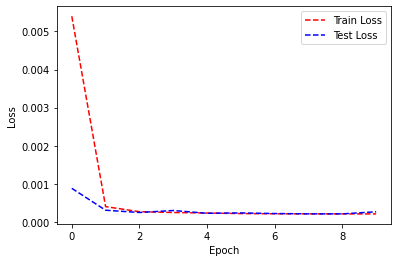

Original Images


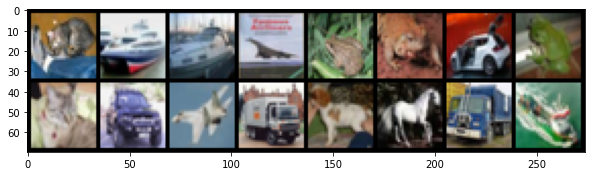

Reconstructed Images


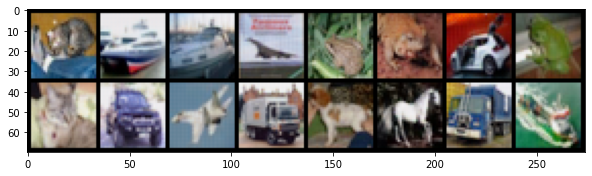

In [25]:
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae11, test_loader)

### Number of layers = 3

In [26]:
ae33 = Autoencoder(3, 3).to(device)
trainLoss, testLoss, epochTime = trainModel(ae33, train_loader, test_loader)


  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1   0.00727462   0.00292012        26.4488
      2   0.00186785   0.00153369        25.9456
      3   0.00136814   0.0013553         25.147
      4   0.00111752   0.00101937        25.3055
      5   0.00100275   0.000935641       25.315
      6   0.000922071  0.000852088       25.1498
      7   0.000850209  0.000836023       25.3677
      8   0.000806569  0.000756217       25.3268
      9   0.000772053  0.000734459       25.7182
     10   0.000741509  0.000704755       25.4148


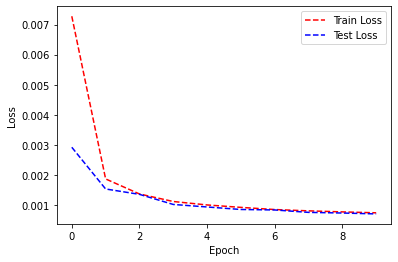

Original Images


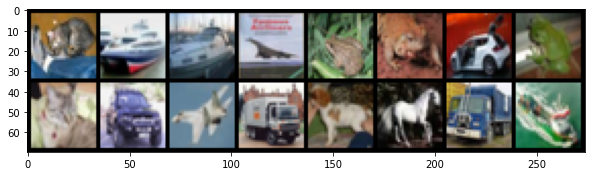

Reconstructed Images


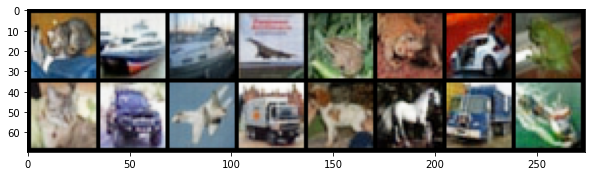

In [27]:
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae33, test_loader)

### Number of layers = 5

In [28]:
ae55 = Autoencoder(5, 5).to(device)
trainLoss, testLoss, epochTime = trainModel(ae55, train_loader, test_loader)


  Epoch    Train Loss    Test Loss    Time Taken
-------  ------------  -----------  ------------
      1    0.0242271    0.015332         36.6045
      2    0.0125151    0.0112716        35.6144
      3    0.010196     0.00951127       36.3339
      4    0.00890938   0.00841178       35.4454
      5    0.00809824   0.0078323        35.7285
      6    0.00759755   0.00734017       36.1044
      7    0.00717753   0.00695022       35.9788
      8    0.00685725   0.00666194       36.03
      9    0.00657528   0.00639833       35.8294
     10    0.00635781   0.00618593       36.5692


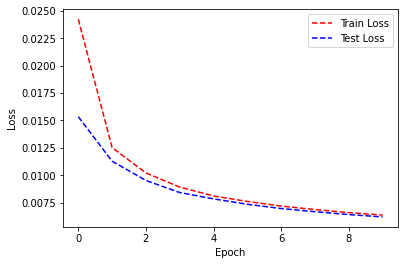

Original Images


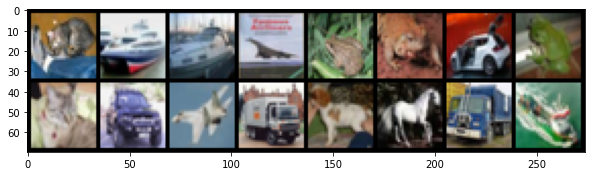

Reconstructed Images


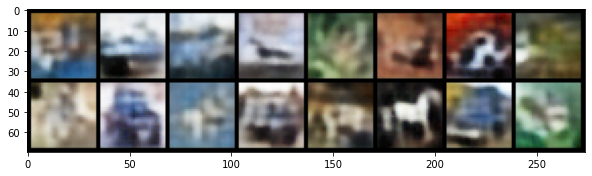

In [29]:
printTable(trainLoss,testLoss,epochTime,epochs)
arr = list(range(epochs))
plot(trainLoss,testLoss,arr)
reconstructImages(ae55, test_loader)

### Number of layers = 10

In [30]:
# ae1010 = Autoencoder(10, 10).to(device)
# summary(ae1010, (3, 32, 32))
# trainLoss, testLoss, epochTime = trainModel(ae1010, train_loader, test_loader)
# printTable(trainLoss,testLoss,epochTime,epochs)
# arr = list(range(epochs))
# plot(trainLoss,testLoss,arr)
# reconstructImages(ae1010, test_loader)

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

Autoencoder can learns compressed representations of input data by compressing it and then reconstructing it back to the original. 
We know that the dimensionality of the data can be reduced using approaches like PCA and t-SNE that are linear and non-linear, respectively, they are unable to detect non-linear correlations between the features.
Autoencoders can be used for image reconstruction and compression.
This learned representation can be used by variational autoencoders to create new data points.
We implemented a simple autoencoder for image reconstruction.

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [31]:
# code and analysis here. Remember to keep your analysis of high quality at all times.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [33]:
# code and analysis here. Remember to keep your analysis of high quality at all times.
def getData(dataset, model):
  X,y = [],[]
  with torch.no_grad():
    for data in dataset:
      image, label = data
      image = image.to(device)
      label = label.to(device)
      features = model.encoder(image)
      X.append(features.view(features.size(0), -1))
      y.append(label)
  return X, y

In [54]:
X_train, y_train = getData(train_loader, ae10)
X_test, y_test = getData(test_loader, ae10)



In [55]:
X_train = torch.cat(X_train).to('cpu').numpy()
X_test = torch.cat(X_test).to('cpu').numpy()


In [56]:
y_train = torch.cat(y_train).to('cpu').numpy()
y_test = torch.cat(y_test).to('cpu').numpy()


In [58]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [59]:

acc = knn.score(X_test, y_test)
print("accuracy is ",acc)

accuracy is  0.3473


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [46]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [47]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [48]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [49]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."